Color quantization example
------------------------------
Here's an example of K-means clustering on images. We're going to start with a couple of images, which live in the `datasets/kmeans/imgs` folder. 

We know that images often have a few dominant colors, e.g. the foreground color and the background color. In this example, we will write some code that uses `scikit-learn`'s K-means clustering algorithm to find the what these dominant colors may be.

Once we know what the most important colors are in an image, we can compress the image (or "quantize", to use fancier terminology) by re-expressing the image using only the set of K colors that we get from the algorithm.

In [1]:
# Set inline plots
%matplotlib inline

In [2]:
# Some useful imports
import os

# You know what these are!
import numpy as np
import matplotlib.pyplot as plt

# This is to help read in image files
import matplotlib.image as mpimg

# This is scikit-learn's implementation of
# the KMeans algorithm
from sklearn.cluster import KMeans

# some extra utilities
from sklearn.utils import shuffle
from time import time

In [3]:
# let's list what images we have to work with
imgs = os.listdir('datasets/kmeans/imgs/')
print imgs

['columbia.jpg', 'mario.png']


Using image 0: path datasets/kmeans/imgs/columbia.jpg


/usr/lib/pymodules/python2.7/matplotlib/image.py:1313: DeprecationWarning: tostring() is deprecated. Please call tobytes() instead.
  x_str = im.tostring('raw', im.mode)


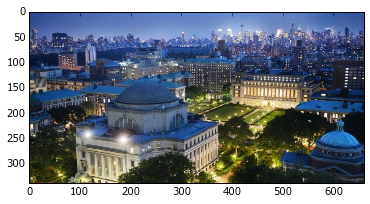

In [18]:
# for now, let's use the first image
img_path = os.path.join('datasets/kmeans/imgs/', imgs[0])
print('Using image 0: path {}'.format(img_path))

img = mpimg.imread(img_path)

# normalize the image values
img = img * 1.0 / img.max()

imgplot = plt.imshow(img)

An image is represented here as a three-dimensional array of floating-point numbers, which can take values from 0 to 1. If we look at ``img.shape``, we'll find that the first two dimensions are x and y, and then the last dimension is the color channel. There are three color channels (one each for red, green, and blue). A set of three channel values at a single (x, y)-coordinate is referred to as a "pixel".

As per usual, we want to pick a small random sample of the data to train with. We're going to use a randomly selected 10% of the image to train our clusters with.

In [19]:
print('Image shape: {}'.format(img.shape))
width, height, num_channels = img.shape
num_pixels = width * height
num_sample_pixels = num_pixels / 10

print('Sampling {} out of {} pixels'.format(num_sample_pixels, num_pixels))

Image shape: (337, 660, 3)
Sampling 22242 out of 222420 pixels


We need to reshape the image data into a single long array of pixels (instead of a two-dimensional array of pixels) in order to take our sample

In [20]:
img_reshaped = np.reshape(img, (num_pixels, num_channels))
img_sample = shuffle(img_reshaped, random_state=0)

Now that we have some data, let's construct our K-means object and feed it some data. It will find the best K clusters, as determined by a distance function

In [21]:
# We're going to try to find the 10 colors which best represent
# the image, i.e. K = 10 clusters
K = 10

t0 = time()
kmeans = KMeans(n_clusters=K, random_state=0)

# Similar to the other scikit-learn code you've seen in the
# past, we can call the fit() function to run the training
# code (in this case, the clustering code). Unlike the
# examples you've seen before, we don't need to pass in a Y
# array, since K-means doesn't need any labels!

kmeans.fit(img_sample)
print("K-means clustering complete. Elapsed time: {} seconds".format(time() - t0))

K-means clustering complete. Elapsed time: 3.4432079792 seconds


The centers of each of the clusters represents a color that was significant in the image. We can grab the values of these colors from `kmeans.cluster_centers_`. We can also call `kmeans.predict()` to match each pixel in the image to the closest color, which will let us know the size of each cluster (and also serve as a way to quantize the image)

In [22]:
# As you can see, there are K cluster centers, each of which is a RGB color
kmeans.cluster_centers_

array([[ 0.59839998,  0.62561943,  0.67375286],
       [ 0.13770403,  0.1613135 ,  0.16324151],
       [ 0.28280721,  0.35536949,  0.48538496]])

In [23]:
t0 = time()
labels = kmeans.predict(img_reshaped)
print("K-means labeling complete. Elapsed time: {} seconds".format(time() - t0))

K-means labeling complete. Elapsed time: 0.0178461074829 seconds


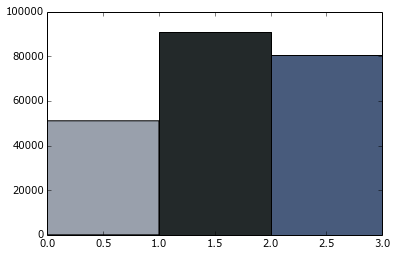

In [24]:
# construct a histogram of the points in each cluster
n, bins, patches = plt.hist(labels, bins=range(K+1))

# We're going to do a bit of magic to color the bins the right color
for p, color in zip(patches, kmeans.cluster_centers_):
    plt.setp(p, 'facecolor', color)

As you might be able to tell from the above histogram, the most dominant color in the scene is the background color, followed by a large drop down to the foreground colors. Of course, this isn't particularly surprising, since visually we can see that the space is mostly filled with the background color -- that's why it's called the "background".

Now, let's redraw the scene using only the cluster centers! This can be used for image compression, since we only need to store the index into the list of cluster centers and the colors corresponding to each center, rather than the colors corresponding to each pixel in the image.

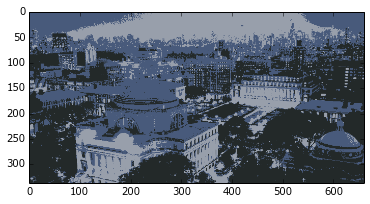

In [25]:
quantized_img = np.zeros(img.shape)
for i in range(width):
    for j in range(height):
        # We need to do some math here to get the correct
        # index position in the labels array
        index = i * height + j
        quantized_img[i][j] = kmeans.cluster_centers_[labels[index]]

quantized_imgplot = plt.imshow(quantized_img)

Note that the image looks almost the same, but that the gradients are no longer as smooth, and there are a few image artifacts scattered throughout. This is because we're only using the K best colors, which does not include the steps along the gradient.

Try running the code through again with a different image, or with a larger (or smaller) value of K!